# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [87]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [88]:
from dotenv import load_dotenv
load_dotenv()
HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")
os.environ["HOPSWORKS_API_KEY"] = HOPSWORKS_API_KEY

In [89]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
yesterday = today - datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 20, 15, 43, 28, 539816)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [90]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1182870
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [91]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [92]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [93]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='3.2347035E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [94]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.07s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-24 00:00:00+00:00,3.25,0.0,15.315873,150.422256,Stockholm
1,2024-11-28 00:00:00+00:00,1.35,0.0,13.896187,323.426880,Stockholm
2,2024-11-23 00:00:00+00:00,-2.65,0.0,11.901798,273.468170,Stockholm
3,2024-11-25 00:00:00+00:00,9.95,0.1,20.124611,206.564987,Stockholm
4,2024-11-26 00:00:00+00:00,8.35,0.0,16.575644,214.380402,Stockholm
5,2024-11-21 00:00:00+00:00,-3.15,0.3,28.585449,301.087433,Stockholm
6,2024-11-27 00:00:00+00:00,6.55,0.1,11.753877,207.349792,Stockholm
7,2024-11-22 00:00:00+00:00,-5.35,0.0,15.188415,264.559753,Stockholm
8,2024-11-29 00:00:00+00:00,0.60,0.0,3.240000,180.000000,Stockholm


### <span style="color:#ff5f27;">🍳 Adding lagged pm25 features</span>

In [95]:
aq_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)

aq_today = aq_fg.filter(aq_fg.date >= yesterday).read()

# sort the data by date
batch_data.sort_values(by="date", inplace=True)
batch_data.reset_index(drop=True, inplace=True)

# Fill tomorrows features with lagged values
batch_data.loc[0, "pm25_lag_1"] = aq_today["pm25"].values[0]
batch_data.loc[0, "pm25_lag_2"] = aq_today["pm25_lag_1"].values[0]
batch_data.loc[0, "pm25_lag_3"] = aq_today["pm25_lag_2"].values[0]

batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.13s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3
0,2024-11-21 00:00:00+00:00,-3.15,0.3,28.585449,301.087433,Stockholm,5.0,1.49,1.2
1,2024-11-22 00:00:00+00:00,-5.35,0.0,15.188415,264.559753,Stockholm,NaN,NaN,NaN
2,2024-11-23 00:00:00+00:00,-2.65,0.0,11.901798,273.468170,Stockholm,NaN,NaN,NaN
3,2024-11-24 00:00:00+00:00,3.25,0.0,15.315873,150.422256,Stockholm,NaN,NaN,NaN
4,2024-11-25 00:00:00+00:00,9.95,0.1,20.124611,206.564987,Stockholm,NaN,NaN,NaN
5,2024-11-26 00:00:00+00:00,8.35,0.0,16.575644,214.380402,Stockholm,NaN,NaN,NaN
6,2024-11-27 00:00:00+00:00,6.55,0.1,11.753877,207.349792,Stockholm,NaN,NaN,NaN
7,2024-11-28 00:00:00+00:00,1.35,0.0,13.896187,323.426880,Stockholm,NaN,NaN,NaN
8,2024-11-29 00:00:00+00:00,0.60,0.0,3.240000,180.000000,Stockholm,NaN,NaN,NaN


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [96]:
# EDITED: We predict each day in sequence in order to use lagged values
for i in range(len(batch_data)):
    batch_data.loc[i, "predicted_pm25"] = retrieved_xgboost_model.predict(
        batch_data.loc[i:i, ['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    
    if i < len(batch_data) - 1:
        batch_data.loc[i+1, "pm25_lag_1"] = batch_data.loc[i, "predicted_pm25"]
        batch_data.loc[i+1, "pm25_lag_2"] = batch_data.loc[i, "pm25_lag_1"]
        batch_data.loc[i+1, "pm25_lag_3"] = batch_data.loc[i, "pm25_lag_2"]


# batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
#     batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25
0,2024-11-21 00:00:00+00:00,-3.15,0.3,28.585449,301.087433,Stockholm,5.000000,1.490000,1.200000,2.746531
1,2024-11-22 00:00:00+00:00,-5.35,0.0,15.188415,264.559753,Stockholm,2.746531,5.000000,1.490000,3.621023
2,2024-11-23 00:00:00+00:00,-2.65,0.0,11.901798,273.468170,Stockholm,3.621023,2.746531,5.000000,3.657040
3,2024-11-24 00:00:00+00:00,3.25,0.0,15.315873,150.422256,Stockholm,3.657040,3.621023,2.746531,6.294475
4,2024-11-25 00:00:00+00:00,9.95,0.1,20.124611,206.564987,Stockholm,6.294475,3.657040,3.621023,4.379627
5,2024-11-26 00:00:00+00:00,8.35,0.0,16.575644,214.380402,Stockholm,4.379627,6.294475,3.657040,3.258650
6,2024-11-27 00:00:00+00:00,6.55,0.1,11.753877,207.349792,Stockholm,3.258650,4.379627,6.294475,3.524512
7,2024-11-28 00:00:00+00:00,1.35,0.0,13.896187,323.426880,Stockholm,3.524512,3.258650,4.379627,1.829031
8,2024-11-29 00:00:00+00:00,0.60,0.0,3.240000,180.000000,Stockholm,1.829031,3.524512,3.258650,4.276443


In [97]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   pm25_lag_1                   9 non-null      float64            
 7   pm25_lag_2                   9 non-null      float64            
 8   pm25_lag_3                   9 non-null      float64            
 9   predicted_pm25               9 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), float64(3), obj

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [98]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-21 00:00:00+00:00,-3.15,0.3,28.585449,301.087433,Stockholm,5.000000,1.490000,1.200000,2.746531,Söder Mälarstrand,Sweden,1
1,2024-11-22 00:00:00+00:00,-5.35,0.0,15.188415,264.559753,Stockholm,2.746531,5.000000,1.490000,3.621023,Söder Mälarstrand,Sweden,2
2,2024-11-23 00:00:00+00:00,-2.65,0.0,11.901798,273.468170,Stockholm,3.621023,2.746531,5.000000,3.657040,Söder Mälarstrand,Sweden,3
3,2024-11-24 00:00:00+00:00,3.25,0.0,15.315873,150.422256,Stockholm,3.657040,3.621023,2.746531,6.294475,Söder Mälarstrand,Sweden,4
4,2024-11-25 00:00:00+00:00,9.95,0.1,20.124611,206.564987,Stockholm,6.294475,3.657040,3.621023,4.379627,Söder Mälarstrand,Sweden,5
5,2024-11-26 00:00:00+00:00,8.35,0.0,16.575644,214.380402,Stockholm,4.379627,6.294475,3.657040,3.258650,Söder Mälarstrand,Sweden,6
6,2024-11-27 00:00:00+00:00,6.55,0.1,11.753877,207.349792,Stockholm,3.258650,4.379627,6.294475,3.524512,Söder Mälarstrand,Sweden,7
7,2024-11-28 00:00:00+00:00,1.35,0.0,13.896187,323.426880,Stockholm,3.524512,3.258650,4.379627,1.829031,Söder Mälarstrand,Sweden,8
8,2024-11-29 00:00:00+00:00,0.60,0.0,3.240000,180.000000,Stockholm,1.829031,3.524512,3.258650,4.276443,Söder Mälarstrand,Sweden,9


In [99]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   pm25_lag_1                   9 non-null      float64            
 7   pm25_lag_2                   9 non-null      float64            
 8   pm25_lag_3                   9 non-null      float64            
 9   predicted_pm25               9 non-null      float32            
 10  street                       9 non-null      object   

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

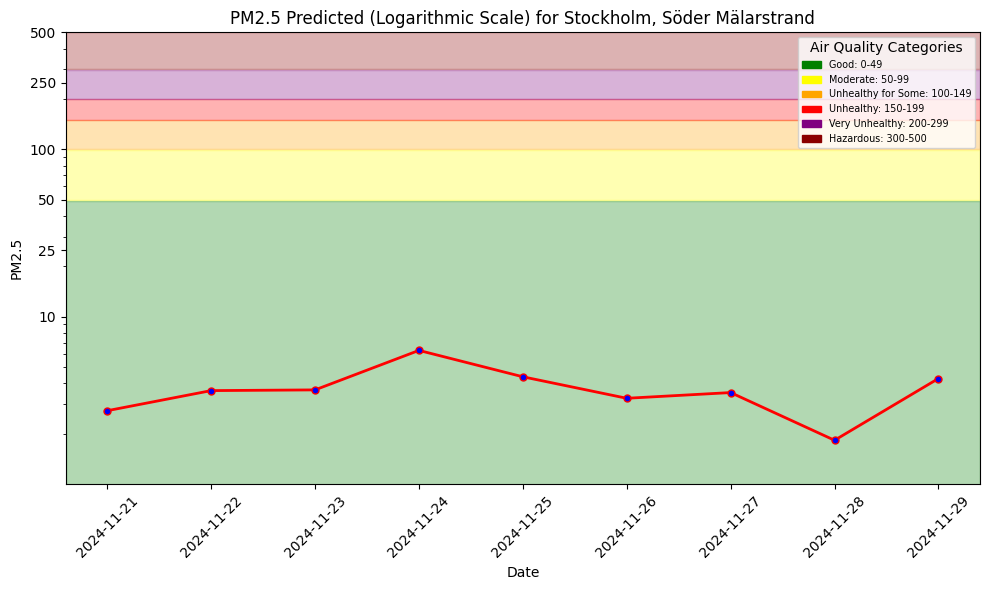

In [100]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [101]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [102]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1182870/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x217df6fbca0>, None)

In [103]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.24s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-21 00:00:00+00:00,-3.15,0.3,28.585449,301.087433,Stockholm,5.0,1.49,1.2,2.746531,Söder Mälarstrand,Sweden,1


In [104]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.33s) 


,date,pm25,pm25_lag_1,pm25_lag_2,pm25_lag_3,country,city,street,url
0,2021-05-26 00:00:00+00:00,1.400000,3.20,3.55,2.23,Sweden,Stockholm,Söder Mälarstrand,https://api.waqi.info/feed/A56749
1,2024-10-05 00:00:00+00:00,2.000000,2.50,1.90,1.30,Sweden,Stockholm,Söder Mälarstrand,https://api.waqi.info/feed/A56749
2,2022-09-24 00:00:00+00:00,2.930000,2.43,1.50,1.20,Sweden,Stockholm,Söder Mälarstrand,https://api.waqi.info/feed/A56749
3,2020-12-05 00:00:00+00:00,20.799999,5.85,9.35,8.43,Sweden,Stockholm,Söder Mälarstrand,https://api.waqi.info/feed/A56749
4,2023-02-15 00:00:00+00:00,7.500000,1.63,1.20,2.20,Sweden,Stockholm,Söder Mälarstrand,https://api.waqi.info/feed/A56749
...,...,...,...,...,...,...,...,...,...
1752,2020-07-10 00:00:00+00:00,1.400000,0.70,0.87,0.67,Sweden,Stockholm,Söder Mälarstrand,https://api.waqi.info/feed/A56749
1753,2023-03-03 00:00:00+00:00,1.200000,1.00,0.90,0.80,Sweden,Stockholm,Söder Mälarstrand,https://api.waqi.info/feed/A56749
1754,2021-07-04 00:00:00+00:00,3.300000,3.50,3.03,2.04,Sweden,Stockholm,Söder Mälarstrand,https://api.waqi.info/feed/A56749
1755,2020-05-26 00:00:00+00:00,2.000000,2.40,3.57,2.14,Sweden,Stockholm,Söder Mälarstrand,https://api.waqi.info/feed/A56749


In [107]:
def backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, model):
    features_df = weather_fg.read()

    air_quality_df['pm25_lag_1'] = air_quality_df['pm25_lag_1'].astype('float64')
    air_quality_df['pm25_lag_2'] = air_quality_df['pm25_lag_2'].astype('float64')
    air_quality_df['pm25_lag_3'] = air_quality_df['pm25_lag_3'].astype('float64')
    
    features_df = pd.merge(features_df, air_quality_df[['date','pm25','pm25_lag_1','pm25_lag_2', 'pm25_lag_3']], on="date")
    features_df = features_df.sort_values(by=['date'], ascending=True)
    features_df = features_df.tail(10)
    
    features_df['predicted_pm25'] = model.predict(features_df[['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    df = pd.merge(features_df, air_quality_df[['date','street','country']], on="date")
    df['days_before_forecast_day'] = 1
    hindcast_df = df
    df = df.drop('pm25', axis=1)
    monitor_fg.insert(df, write_options={"wait_for_job": True})
    return hindcast_df


In [109]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# print(weather_fg.show(2))
# print(air_quality_fg.show(2))

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.10s) 


Uploading Dataframe: 0.00% |          | Rows 0/10 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1182870/jobs/named/aq_predictions_1_offline_fg_materialization/executions


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-10 00:00:00+00:00,5.512333,0.1,9.292255,145.380463,Stockholm,1.47,4.90,1.87,1.12,6.599525,Söder Mälarstrand,Sweden,1
1,2024-11-11 00:00:00+00:00,4.908166,1.1,9.676569,234.773972,Stockholm,7.40,1.47,4.90,1.87,2.701587,Söder Mälarstrand,Sweden,1
2,2024-11-12 00:00:00+00:00,3.070667,0.0,10.990322,288.903290,Stockholm,1.09,7.40,1.47,4.90,6.803674,Söder Mälarstrand,Sweden,1
3,2024-11-13 00:00:00+00:00,3.472750,0.0,15.124284,238.321777,Stockholm,2.20,1.09,7.40,1.47,1.810442,Söder Mälarstrand,Sweden,1
4,2024-11-14 00:00:00+00:00,4.581084,0.0,15.275627,296.519409,Stockholm,1.83,2.20,1.09,7.40,1.238624,Söder Mälarstrand,Sweden,1
5,2024-11-15 00:00:00+00:00,6.139417,0.0,23.569693,259.886078,Stockholm,1.97,1.83,2.20,1.09,1.713147,Söder Mälarstrand,Sweden,1
6,2024-11-16 00:00:00+00:00,7.906084,0.0,28.503725,244.979889,Stockholm,1.77,1.97,1.83,2.20,2.009892,Söder Mälarstrand,Sweden,1
7,2024-11-17 00:00:00+00:00,4.966500,0.0,24.613312,255.108246,Stockholm,1.93,1.77,1.97,1.83,1.386508,Söder Mälarstrand,Sweden,1
8,2024-11-18 00:00:00+00:00,1.656083,0.0,16.293728,277.615173,Stockholm,1.20,1.93,1.77,1.97,1.306069,Söder Mälarstrand,Sweden,1
9,2024-11-20 00:00:00+00:00,1.400000,0.1,23.510508,348.518036,Stockholm,5.00,1.49,1.20,1.93,1.384760,Söder Mälarstrand,Sweden,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

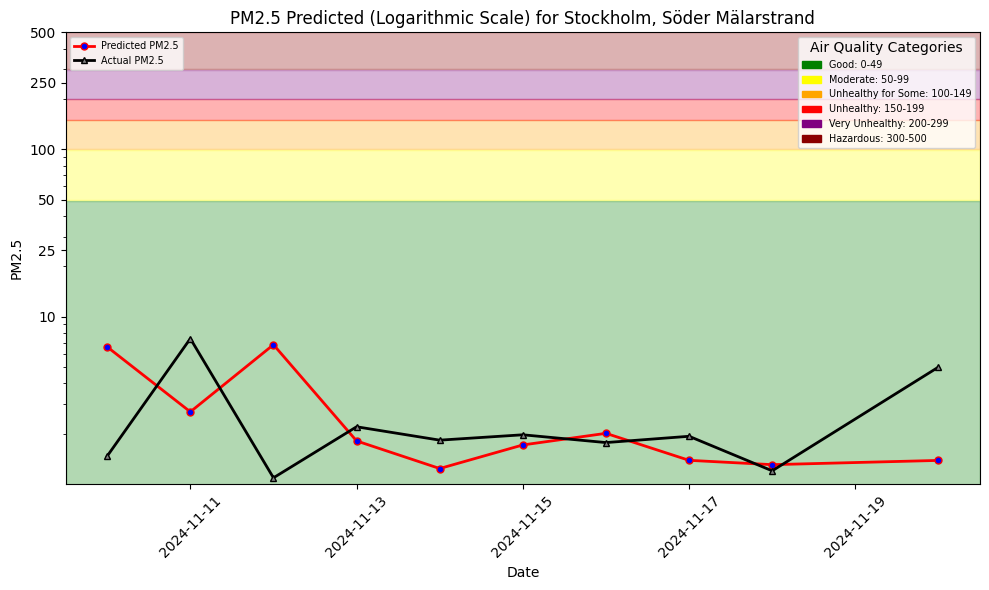

In [110]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---